<a href="https://colab.research.google.com/github/EricPostMaster/coursera-datascience-capstone/blob/master/Restaurant_Opening_Jupyter_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project Notebook
       Created by Eric Sims

## Methodology

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Import Home Value Data
I downloaded and cleaned Zillow Home Value Index data for all of North Carolina and segmented out only the largest 150 zip codes in the state, figuring that the great majority of people live in those areas.

In [2]:
df_data_1 = pd.read_csv('/content/NC-ZHVI.csv')
df_data_1.head()

,ZipCode,City,SizeRank,2015,2015Weight,2016,2016Weight,2017,2017Weight,2018,2018Weight,2019,2019Weight
0,28269,Charlotte,1,161155,1,172662,2,189549,3,207802,4,222079,5
1,28277,Charlotte,2,300910,1,318152,2,339128,3,357253,4,366603,5
2,28027,Concord,3,196663,1,205240,2,222421,3,237999,4,250122,5
3,27587,Wake Forest,4,285567,1,295697,2,307897,3,319676,4,330524,5
4,28078,Huntersville,5,261813,1,276244,2,293663,3,309628,4,318790,5


### Calculate the percent growth in home value since 2015 by zip code:

In [3]:
percent_growth = round(100*((df_data_1["2019"] - df_data_1["2015"])/df_data_1["2015"]),2)

percent_growth[0:5]

0    37.80
1    21.83
2    27.18
3    15.74
4    21.76
dtype: float64

Okay, so that is the growth from 2015-2019.

### Add to dataframe

In [4]:
df_data_1["Growth"] = percent_growth
df_data_1.head()

,ZipCode,City,SizeRank,2015,2015Weight,2016,2016Weight,2017,2017Weight,2018,2018Weight,2019,2019Weight,Growth
0,28269,Charlotte,1,161155,1,172662,2,189549,3,207802,4,222079,5,37.80
1,28277,Charlotte,2,300910,1,318152,2,339128,3,357253,4,366603,5,21.83
2,28027,Concord,3,196663,1,205240,2,222421,3,237999,4,250122,5,27.18
3,27587,Wake Forest,4,285567,1,295697,2,307897,3,319676,4,330524,5,15.74
4,28078,Huntersville,5,261813,1,276244,2,293663,3,309628,4,318790,5,21.76


### Look for outliers to focus on

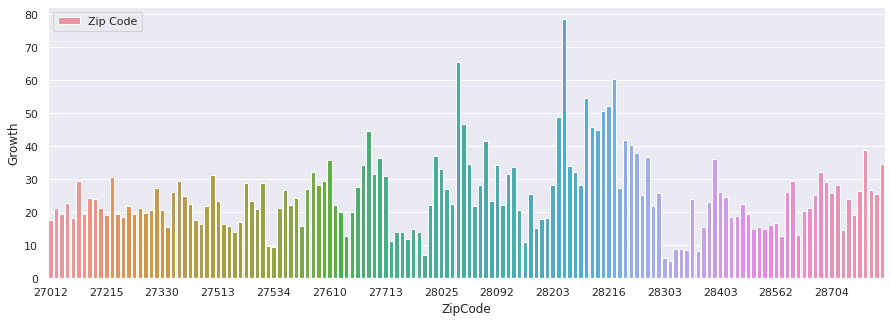

In [5]:
fig, ax = plt.subplots(figsize=(15,5))

ax = sns.barplot(x="ZipCode", y="Growth", data=df_data_1, label="Zip Code")
temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::10]))
for label in temp:
    label.set_visible(False)
ax.legend(loc="upper left")

From this we can see that almost everywhere has seen 15%-30% growth over the past 5 years.  There are 10-15 places that have seen over 40% growth.  We want to focus on them!

### Separate out the top values to focus on

In [6]:
df_top_charlotte = df_data_1.sort_values(by='Growth', ascending=False)[0:5]
df_top_charlotte

,ZipCode,City,SizeRank,2015,2015Weight,2016,2016Weight,2017,2017Weight,2018,2018Weight,2019,2019Weight,Growth
81,28208,Charlotte,82,83099,1,93417,2,111611,3,131912,4,148220,5,78.37
102,28052,Gastonia,103,71351,1,76418,2,88737,3,101775,4,117987,5,65.36
131,28217,Charlotte,132,96948,1,106697,2,121787,3,141973,4,155477,5,60.37
68,28212,Charlotte,69,121155,1,131807,2,149064,3,171456,4,187153,5,54.47
19,28216,Charlotte,20,122057,1,135649,2,152232,3,169632,4,185619,5,52.08


So, it looks like four out of the top 5 growing zip codes are located in the Charlotte, NC area.  Let's focus on them.  Let's filter out that Gastonia zip code:

In [7]:
condition = df_top_charlotte["City"] == "Charlotte"

df_top_charlotte = df_top_charlotte[condition]

df_top_charlotte = df_top_charlotte.rename(columns={"ZipCode": "zipcode"})
df_top_charlotte

,zipcode,City,SizeRank,2015,2015Weight,2016,2016Weight,2017,2017Weight,2018,2018Weight,2019,2019Weight,Growth
81,28208,Charlotte,82,83099,1,93417,2,111611,3,131912,4,148220,5,78.37
131,28217,Charlotte,132,96948,1,106697,2,121787,3,141973,4,155477,5,60.37
68,28212,Charlotte,69,121155,1,131807,2,149064,3,171456,4,187153,5,54.47
19,28216,Charlotte,20,122057,1,135649,2,152232,3,169632,4,185619,5,52.08


### Map the zip codes using Folium

In [8]:
!pip install folium
import folium

In [0]:
charlotte_map = folium.Map(location=[35.2271, -80.8431], zoom_start=10)

charlotte_geo = '/content/meckzipcodes2.geojson'

Lesson learned here!  Make sure that the data type of your key_on column matches the data type of the column it is connected to in your dataframe!  My zip codes were strings in the geojson file, and that took a while to fix.

In [10]:
charlotte_map = folium.Map(location=[35.2271, -80.8431], zoom_start=11)

folium.Choropleth(
    geo_data=charlotte_geo,
    data=df_top_charlotte,
    columns=['zipcode', 'Growth'],
    key_on='feature.properties.zipcode',
    fill_color='YlOrRd', 
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Growth in Charlotte",
    highlight=True
).add_to(charlotte_map)

charlotte_map

### Query data from the Foursquare API
First we will save the client query info to Python objects:

In [0]:
# @hidden_cell
client_id = '4O22F2EMXXKWC2BE3S40GIROQFI4BC232YL0BC1PQXNP4I0T'
client_secret = 'QVE25XYPVATCJTGVR31B3CT3K310BGJFA4VBKTPSHGLYMRT5'
radius = 13680 #This is an 8.5-mile radius to stay outside of central Charlotte
radius2 = 5632 #3.5-mile radius
radius3 = 4828 #3-mile radius
venue_count = 150
section = 'food'
version = '20200331'
charlotte_lat = 35.320981
charlotte_lon = -80.944489
charlotte_lat2 = 35.164533
charlotte_lon2 = -80.936224
charlotte_lat3 = 35.203451
charlotte_lon3 = -80.741009

In [12]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
    client_id, 
    client_secret, 
    version, 
    charlotte_lat, 
    charlotte_lon, 
    radius, 
    venue_count,
    section)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=4O22F2EMXXKWC2BE3S40GIROQFI4BC232YL0BC1PQXNP4I0T&client_secret=QVE25XYPVATCJTGVR31B3CT3K310BGJFA4VBKTPSHGLYMRT5&v=20200331&ll=35.320981,-80.944489&radius=13680&limit=150&section=food'

In [13]:
url2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
    client_id, 
    client_secret, 
    version, 
    charlotte_lat2, 
    charlotte_lon2, 
    radius2, 
    venue_count,
    section)
url2

'https://api.foursquare.com/v2/venues/explore?&client_id=4O22F2EMXXKWC2BE3S40GIROQFI4BC232YL0BC1PQXNP4I0T&client_secret=QVE25XYPVATCJTGVR31B3CT3K310BGJFA4VBKTPSHGLYMRT5&v=20200331&ll=35.164533,-80.936224&radius=5632&limit=150&section=food'

In [14]:
url3 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
    client_id, 
    client_secret, 
    version, 
    charlotte_lat3, 
    charlotte_lon3, 
    radius3, 
    venue_count,
    section)
url3

'https://api.foursquare.com/v2/venues/explore?&client_id=4O22F2EMXXKWC2BE3S40GIROQFI4BC232YL0BC1PQXNP4I0T&client_secret=QVE25XYPVATCJTGVR31B3CT3K310BGJFA4VBKTPSHGLYMRT5&v=20200331&ll=35.203451,-80.741009&radius=4828&limit=150&section=food'

In [0]:
import requests
from pandas.io.json import json_normalize

In [28]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e84b70cc94979001bb4f6d7'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-3-4b5de371f964a5203d7229e3-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/fastfood_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d16e941735',
         'name': 'Fast Food Restaurant',
         'pluralName': 'Fast Food Restaurants',
         'primary': True,
         'shortName': 'Fast Food'}],
       'id': '4b5de371f964a5203d7229e3',
       'location': {'address': '9731 Callabridge Ct',
        'cc': 'US',
        'city': 'Charlotte',
        'country': 'United States',
        'distance': 654,
        'formattedAddress': ['9731 Callabridge Ct',
         'Charlotte, NC 28216',
         'United States'],
        'labeledLatLngs': [{'label': '

In [17]:
results2 = requests.get(url2).json()
results2

{'meta': {'code': 200, 'requestId': '5e84b6837828ae001b800b98'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-3-4b575d62f964a520c23328e3-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/friedchicken_',
          'suffix': '.png'},
         'id': '4d4ae6fc7a7b7dea34424761',
         'name': 'Fried Chicken Joint',
         'pluralName': 'Fried Chicken Joints',
         'primary': True,
         'shortName': 'Fried Chicken'}],
       'id': '4b575d62f964a520c23328e3',
       'location': {'address': '7508 S Tryon St',
        'cc': 'US',
        'city': 'Charlotte',
        'country': 'United States',
        'distance': 1865,
        'formattedAddress': ['7508 S Tryon St',
         'Charlotte, NC 28217',
         'United States'],
        'labeledLatLngs': [{'label': 'd

In [18]:
results3 = requests.get(url3).json()
results3

{'meta': {'code': 200, 'requestId': '5e84b67847e0d600269e117d'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-3-4f0e1902e4b0dd893113704e-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d144941735',
         'name': 'Caribbean Restaurant',
         'pluralName': 'Caribbean Restaurants',
         'primary': True,
         'shortName': 'Caribbean'}],
       'delivery': {'id': '1322140',
        'provider': {'icon': {'name': '/delivery_provider_grubhub_20180129.png',
          'prefix': 'https://fastly.4sqi.net/img/general/cap/',
          'sizes': [40, 50]},
         'name': 'grubhub'},
        'url': 'https://www.grubhub.com/restaurant/island-grocery-5861-albemarle-road-charlotte/1322140?affiliat

In [0]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [29]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Chick-fil-A,Fast Food Restaurant,35.326858,-80.944759
1,Shuffletown Drive-in,Breakfast Spot,35.321630,-80.952922
2,Heirloom,Southern / Soul Food Restaurant,35.305047,-80.937486
3,Freddy's Frozen Custard & Steakburgers,Burger Joint,35.326412,-80.943360
4,Tony's Pizza,Pizza Place,35.357312,-80.868105


In [26]:
venues2 = results2['response']['groups'][0]['items']
    
nearby_venues2 = json_normalize(venues2) # flatten JSON

# filter columns
filtered_columns2 = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues2 =nearby_venues2.loc[:, filtered_columns2]

# filter the category for each row
nearby_venues2['venue.categories'] = nearby_venues2.apply(get_category_type, axis=1)

# clean columns
nearby_venues2.columns = [col.split(".")[-1] for col in nearby_venues2.columns]

nearby_venues2.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Zaxby's Chicken Fingers & Buffalo Wings,Fried Chicken Joint,35.150300,-80.925411
1,Firehouse Subs,Sandwich Place,35.139710,-80.934993
2,Nana's Soul Food Kitchen,Southern / Soul Food Restaurant,35.190075,-80.921903
3,Siam Garden,Thai Restaurant,35.151786,-80.950608
4,"Highway 55 Burgers, Shakes, & Fries",American Restaurant,35.171091,-80.963202


In [27]:
venues3 = results3['response']['groups'][0]['items']
    
nearby_venues3 = json_normalize(venues3) # flatten JSON

# filter columns
filtered_columns3 = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues3 =nearby_venues3.loc[:, filtered_columns3]

# filter the category for each row
nearby_venues3['venue.categories'] = nearby_venues3.apply(get_category_type, axis=1)

# clean columns
nearby_venues3.columns = [col.split(".")[-1] for col in nearby_venues3.columns]

nearby_venues3.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Island Grocery Caribbean Restaurant,Caribbean Restaurant,35.203821,-80.746209
1,Pho an Hoa,Vietnamese Restaurant,35.211579,-80.761481
2,Cook-Out,Burger Joint,35.202062,-80.734876
3,Al-Basha,Mediterranean Restaurant,35.203522,-80.760600
4,Popeyes Louisiana Kitchen,Fried Chicken Joint,35.203604,-80.743044


In [30]:
print('{} venues were returned by Foursquare for west Charlotte.'.format(nearby_venues.shape[0]))
print('{} venues were returned by Foursquare for southwest Charlotte.'.format(nearby_venues2.shape[0]))
print('{} venues were returned by Foursquare for southeast Charlotte.'.format(nearby_venues3.shape[0]))

100 venues were returned by Foursquare for west Charlotte.
100 venues were returned by Foursquare for southwest Charlotte.
100 venues were returned by Foursquare for southeast Charlotte.


In [31]:
charlotte_map = folium.Map(location=[35.2271, -80.8431], zoom_start=11)

folium.Choropleth(
    geo_data=charlotte_geo,
    data=df_top_charlotte,
    columns=['zipcode', 'Growth'],
    key_on='feature.properties.zipcode',
    fill_color='YlOrRd', 
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Growth in Charlotte",
    highlight=True
).add_to(charlotte_map)

for i in range(0,len(nearby_venues)):
    folium.CircleMarker(([nearby_venues.iloc[i]['lat'], nearby_venues.iloc[i]['lng']]), 
                        popup=nearby_venues.iloc[i]['name'], fill=True, 
                        fill_opacity=.3, 
                        # fill_color=nearby_venues.iloc[i]['Marker Color'], 
                        # color=nearby_venues.iloc[i]['Marker Color']
                        ).add_to(charlotte_map)

for i in range(0,len(nearby_venues2)):
    folium.CircleMarker(([nearby_venues2.iloc[i]['lat'], nearby_venues2.iloc[i]['lng']]), 
                        popup=nearby_venues2.iloc[i]['name'], fill=True, 
                        fill_opacity=.3, 
                        # fill_color=nearby_venues2.iloc[i]['Marker Color'], 
                        # color=nearby_venues2.iloc[i]['Marker Color']
                        ).add_to(charlotte_map)

for i in range(0,len(nearby_venues3)):
    folium.CircleMarker(([nearby_venues3.iloc[i]['lat'], nearby_venues3.iloc[i]['lng']]), 
                        popup=nearby_venues3.iloc[i]['name'], fill=True, 
                        fill_opacity=.3, 
                        # fill_color=nearby_venues3.iloc[i]['Marker Color'], 
                        # color=nearby_venues3.iloc[i]['Marker Color']
                        ).add_to(charlotte_map)

charlotte_map

## Concatenate all three venues dataframes and remove duplicates

In [0]:
all_dataframes = [nearby_venues, nearby_venues2, nearby_venues3]

In [33]:
all_venues = pd.concat(all_dataframes)
all_venues.shape

(300, 4)

In [0]:
all_venues.drop_duplicates(keep=False, inplace=True)

### Check shape to see how many were removed
Looks like we only had two duplicates.  Great!

In [35]:
all_venues.shape

(298, 4)

In [36]:
all_venues.head()

,name,categories,lat,lng
0,Chick-fil-A,Fast Food Restaurant,35.326858,-80.944759
1,Shuffletown Drive-in,Breakfast Spot,35.321630,-80.952922
2,Heirloom,Southern / Soul Food Restaurant,35.305047,-80.937486
3,Freddy's Frozen Custard & Steakburgers,Burger Joint,35.326412,-80.943360
4,Tony's Pizza,Pizza Place,35.357312,-80.868105


## k-Means Clustering Analysis
### First, Elbow Plot to determine optimal cluster count

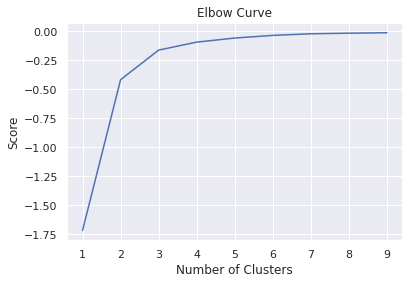

In [38]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
y_axis = all_venues[['lat']]
x_axis = all_venues[['lng']]
score = [kmeans[i].fit(y_axis).score(y_axis) for i in range(len(kmeans))]

# Graph out the scores by the number of clusters
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

This is actually much smaller than I expected, considering the wide spread of locations on the map above.  We're going to use our domain knowledge to trump what the elbow curve says and try a larger number of clusters.

### Now to actually determine the clusters...

In [0]:
kmeans = KMeans(n_clusters = 8, init = 'k-means++')  #Decided to go with 8 clusters
kmeans.fit(all_venues[all_venues.columns[3:5]])

all_venues["Cluster Assignment"] = kmeans.fit_predict(all_venues[all_venues.columns[3:5]])

In [69]:
all_venues.head()

,name,categories,lat,lng,Cluster Assignment,Marker Color
0,Chick-fil-A,Fast Food Restaurant,35.326858,-80.944759,0,blue
1,Shuffletown Drive-in,Breakfast Spot,35.321630,-80.952922,7,blue
2,Heirloom,Southern / Soul Food Restaurant,35.305047,-80.937486,0,blue
3,Freddy's Frozen Custard & Steakburgers,Burger Joint,35.326412,-80.943360,0,blue
4,Tony's Pizza,Pizza Place,35.357312,-80.868105,2,red


In [0]:
labels = all_venues["Cluster Assignment"]

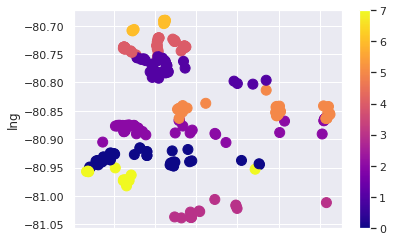

In [71]:
all_venues.plot.scatter(x = 'lat', y = 'lng', c=labels, s=100, cmap="plasma")

### Now to plot the clusters on Folium
First, we need to assign a color to each of the markers:

In [72]:
clusters = all_venues["Cluster Assignment"].to_numpy()
clusters[0:5]

array([0, 7, 0, 0, 2], dtype=int32)

In [73]:
marker_color = []
i=0

for number in clusters:
    if clusters[i] == 7:
        marker_color.append("red")
    elif clusters[i] == 6:
        marker_color.append("orange")
    elif clusters[i] == 5:
        marker_color.append("yellow")
    elif clusters[i] == 4:
        marker_color.append("green")
    elif clusters[i] == 3:
        marker_color.append("blue")
    elif clusters[i] == 2:
        marker_color.append("purple")
    elif clusters[i] == 1:
        marker_color.append("black")
    else:
        marker_color.append("pink")
    i+=1

marker_color[0:5]

['pink', 'red', 'pink', 'pink', 'purple']

### Add markers to the dataframe

In [0]:
all_venues["Marker Color"] = marker_color

In [75]:
all_venues.head()

,name,categories,lat,lng,Cluster Assignment,Marker Color
0,Chick-fil-A,Fast Food Restaurant,35.326858,-80.944759,0,pink
1,Shuffletown Drive-in,Breakfast Spot,35.321630,-80.952922,7,red
2,Heirloom,Southern / Soul Food Restaurant,35.305047,-80.937486,0,pink
3,Freddy's Frozen Custard & Steakburgers,Burger Joint,35.326412,-80.943360,0,pink
4,Tony's Pizza,Pizza Place,35.357312,-80.868105,2,purple


In [76]:
charlotte_map = folium.Map(location=[35.2271, -80.8431], zoom_start=11)

folium.Choropleth(
    geo_data=charlotte_geo,
    data=df_top_charlotte,
    columns=['zipcode', 'Growth'],
    key_on='feature.properties.zipcode',
    fill_color='YlOrRd', 
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Growth in Charlotte",
    highlight=True
).add_to(charlotte_map)

for i in range(0,len(all_venues)):
    folium.CircleMarker(([all_venues.iloc[i]['lat'], all_venues.iloc[i]['lng']]), 
                        popup=all_venues.iloc[i]['name'], fill=True, 
                        fill_opacity=.3, 
                        fill_color=all_venues.iloc[i]['Marker Color'], 
                        color=all_venues.iloc[i]['Marker Color']
                        ).add_to(charlotte_map)

charlotte_map